## Import libraries

In [73]:
# Default libraries
import copy
import tqdm
import numpy as np
import seaborn as sns
import scipy.signal as signal
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import json

# Custom libraries
import Functions.data_tools as data_tools
from Functions.temple_data import TempleData
from Functions.artifact_removal_tool import ART
from Functions import eeg_quality_index as eqi
from Functions import optimization as optimization

# Magic command to automatically reload modules
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [2]:
# List of files for the whole analysis
files = [
    r"Data\Temple\edf\01_tcp_ar\009\00000906\s005_2003_04_27\00000906_s005_t000.edf", # Si
    r"Data\Temple\edf\01_tcp_ar\009\00000906\s016_2012_03_01\00000906_s016_t000.edf", # Mejor que el pasado
    r"Data\Temple\edf\01_tcp_ar\012\00001217\s002_2012_09_17\00001217_s002_t000.edf", # Si pero tiene muchos single channel
    r"Data\Temple\edf\01_tcp_ar\027\00002705\s003_2009_12_04\00002705_s003_t000.edf", # Si
    r"Data\Temple\edf\01_tcp_ar\045\00004526\s003_2009_09_15\00004526_s003_t001.edf", # Si
    r"Data\Temple\edf\01_tcp_ar\045\00004526\s006_2010_07_27\00004526_s006_t001.edf", # Si pero es el mismo sujeto que el pasado
    r"Data\Temple\edf\01_tcp_ar\045\00004586\s002_2009_10_07\00004586_s002_t001.edf", # Si pero es el mismo que el pasado
    r"Data\Temple\edf\01_tcp_ar\052\00005230\s002_2010_09_07\00005230_s002_t000.edf", # Si
    ]

## General Settings

In [3]:
# Settings
artifact_type = "eyem"
window_length = 2   # Window length for artifact [sec]
var_tol = 1e-15  # Threshold for variance tolerance (used in ART) | default=1e-15

# Optimization hyperparameters
n_clusters = (1, 10)
fd_threshold = (0.1, 10)
ssa_threshold = (0.001, 0.1)
bounds = (n_clusters, fd_threshold, ssa_threshold)

In [4]:
def simulated_annealing_optimizer(
    func,
    bounds,
    args,
    callback = lambda intermediate_result: None,
    display = True,
    max_iter = 100,
    max_stag_count = 20,
    x_err_tol = 0.1,
    MR = 0.5
    ):

    # Configurables
    max_stag_count = max_stag_count # maximum number of iterations where x_err hasn't changed
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # tolerance for x_err (stop searching for a better solution when x_err < x_err_tol)
    MR = MR # mutation rate

    # Simulated annealing params
    T = 1
    alpha = 0.99
    beta = 1
    update_iters = 1

    def generate_candidate(bounds=bounds, args = args):
        x = [(np.random.uniform(bounds[d][0], bounds[d][1])) for d in range(len(bounds))]
        return x, func(x, *args)

    def generate_neighboring_candidate(x, MR=MR, bounds=bounds, args = args):
        x_new = copy.deepcopy(x)
        for i in range(len(x)):
            if np.random.uniform(0, 1) < MR:
                x_new[i] = np.random.uniform(bounds[i][0], bounds[i][1])
        return x_new, func(x_new, *args)

    x, x_err = generate_candidate(bounds, args) # generate a random x (particle/candidate) and its error (cost/objective/fitness function value)
    x_best = x.copy() # best solution found so far
    x_best_err = x_err # best error for that solution

    prev_x_err = x_err # previous iteration's x_err
    stag_count = 0 # number of iterations where x_err hasn't changed
    max_stag_count = max_stag_count # generate a new starting candidate if x_err hasn't changed for max_stag_count iterations

    # Stopping conditions
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # stop searching for a better solution when x_err < x_err_tol

    pbar = tqdm() if display else None # progress bar
    n_iter = 1
    try:
        while (abs(x_best_err) > x_err_tol) and (n_iter < max_iter):
            
            if display:
                pbar.set_description(f'x_best_err: {x_best_err:.4f}')
                pbar.update(1)

            prev_x_err = x_err
            stag_count = stag_count + 1 if prev_x_err == x_err else 0

            x_new, x_new_err = generate_neighboring_candidate(
                x = x,
                MR = MR,
                bounds = bounds,
                args = args
                )

            if x_new_err <= x_err:
                x, x_err = x_new, x_new_err
                if x_err <= x_best_err:
                    x_best, x_best_err = x, x_err
            else:
                if np.random.uniform(0, 1) < np.exp(-beta * (x_new_err - x_err)/T):
                    x, x_err = x_new, x_new_err
                    
            if n_iter % update_iters == 0:
                T = alpha*T
                T = T if T > 0.01 else 0.01

            n_iter += 1

            callback((x_best, x_best_err))

    except KeyboardInterrupt:
        pass
    finally:
        pbar.close() if display else None

    print(f"x_best_err: {x_best_err:.4f} after {n_iter} iterations")

    return x_best, x_best_err

def heuristic_optimizer(
        func,
        bounds,
        args,
        callback = lambda intermediate_result: None,
        display = True,
        max_iter = 100,
        max_stag_count = 20,
        x_err_tol = 0.1,
        MR = 0.5
        ):

    # Configurables
    max_stag_count = max_stag_count # maximum number of iterations where x_err hasn't changed
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # tolerance for x_err (stop searching for a better solution when x_err < x_err_tol)
    MR = MR # mutation rate

    def generate_candidate(bounds=bounds, args = args):
        x = [(np.random.uniform(bounds[d][0], bounds[d][1])) for d in range(len(bounds))]
        return x, func(x, *args)

    def generate_neighboring_candidate(x, MR=MR, bounds=bounds, args = args):
        x_new = copy.deepcopy(x)
        for i in range(len(x)):
            if np.random.uniform(0, 1) < MR:
                x_new[i] = np.random.uniform(bounds[i][0], bounds[i][1])
        return x_new, func(x_new, *args)

    x, x_err = generate_candidate(bounds, args) # generate a random x (particle/candidate) and its error (cost/objective/fitness function value)
    x_best = x.copy() # best solution found so far
    x_best_err = x_err # best error for that solution

    prev_x_err = x_err # previous iteration's x_err
    stag_count = 0 # number of iterations where x_err hasn't changed
    max_stag_count = max_stag_count # generate a new starting candidate if x_err hasn't changed for max_stag_count iterations

    # Stopping conditions
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # stop searching for a better solution when x_err < x_err_tol

    pbar = tqdm() if display else None # progress bar
    n_iter = 1
    try:
        while abs(x_best_err) > x_err_tol and n_iter < max_iter:
            
            if display:
                pbar.set_description(f'x_best_err: {x_best_err:.4f}')
                pbar.update(1)

            prev_x_err = x_err
            stag_count = stag_count + 1 if prev_x_err == x_err else 0
            
            # Generate a random neighbor of x and calculate its error
            if stag_count > max_stag_count:
                x_new, x_new_err = generate_candidate(bounds, args)
                stag_count = 0
            else:
                x_new, x_new_err = copy.deepcopy(x), x_err
                x_new, x_new_err = generate_neighboring_candidate(x = x_new, MR = MR, bounds=bounds, args=args)

            # Update x and x_err if the new solution is better
            if x_new_err < x_err:
                x, x_err = x_new, x_new_err # if x_new is better, update x and x_err
                if x_err < x_best_err:
                    x_best, x_best_err = x, x_err # if x_new is the best, update x_best and x_best_err

            n_iter += 1

            callback((x_best, x_best_err))

    except KeyboardInterrupt:
        pass
    finally:
        pbar.close() if display else None

    print(f"x_best_err: {x_best_err:.4f} after {n_iter} iterations")

    return x_best, x_best_err

## Optimization

In [5]:
results = {}

for file in files:
    # Import data file
    temple = TempleData(file)

    # Get artifact data
    artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
    # artifacts_file = fr"/home/araz/Downloads/Araz/csv/labels_{temple.montage_type}.csv"
    temple.get_artifacts_from_csv(artifacts_file)

    [artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
        artifact_type = artifact_type,
        window_length = window_length,
        )

    # Get clean data
    clean = temple.get_clean_data(window_length)
    clean_avg = signal.detrend(clean[10,:,:])

    # Split list into optimization and testing artifacts
    [ioptimization, itest] = data_tools.split_list(
        lst = list(range(5)),
        test_percentage = 20,
        seed = 42
        )
    
    # Save iteration results
    file_id = file.split("\\")[-1].split(".")[0]
    results[file_id] = {}
    results[file_id].update({
        "file_path": file,
        "optimization_artifacts": ioptimization,
        "test_artifacts": itest,
        })
    results[file_id]["optimization parameters"] = []

    # Perform optimization per artifact
    for a, artifact in enumerate([artifacts_chans[i] for i in ioptimization]):
        
        temp_results = []

        # Get subset of channels based on artifact
        subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

        # Constant arguments
        args = (
            clean_avg[subset_chans,:],
            signal.detrend(artifacts_data[ioptimization[a]][:,:]), 
            temple.srate,
            window_length,
            var_tol
            )
        
        optimization_results = simulated_annealing_optimizer(
            func = optimization.maximize_eqi,
            bounds = bounds,
            args = args,
            display=False,
            # polish = True,
            callback = lambda intermediate_result: temp_results.append(intermediate_result),
            max_iter = 100,
            MR = 0.5
            )
        
        results[file_id]["optimization parameters"].append(optimization_results)

    # Save best set of parameters
    # Initialize the minimum objective function and the corresponding hyperparameters
    min_obj = float('inf')
    min_hyp = None

    # Loop through the list and compare each objective function with the current minimum
    for hyp, obj in results[file_id]["optimization parameters"]:
        if obj < min_obj:
            # Update the minimum objective function and the corresponding hyperparameters
            min_obj = obj
            min_hyp = hyp

    results[file_id]["best parameters"] = min_hyp


    # Compute test EQIs
    subset_chans = [temple.ch_names.index(chan) for chan in artifacts_chans[itest[0]] if chan in temple.ch_names]
    raw_artifact = signal.detrend(artifacts_data[itest[0]])
    raw_eqi = eqi.scoring(
        clean_eeg = clean_avg[subset_chans,:],
        test_eeg = raw_artifact,
        srate_clean = temple.srate,
        srate_test = temple.srate,
        window = int(temple.srate // 10),
        slide =  int(temple.srate // 20)
        )[1]
    

    # Optimized artifact
    art = ART(
        window_length = int(temple.srate // 2),  # To have 500 msec windows like the paper
        n_clusters = int(results[file_id]["best parameters"][0]),
        fd_threshold = results[file_id]["best parameters"][1],
        ssa_threshold = results[file_id]["best parameters"][2],
        var_tol = var_tol
        )

    # Apply artifact removal
    optimized_artifact = art.remove_artifacts(
        eeg_data = raw_artifact,
        srate = temple.srate
        )
    
    optimized_eqi = eqi.scoring(
        clean_eeg = clean_avg[subset_chans,:],
        test_eeg = optimized_artifact,
        srate_clean = temple.srate,
        srate_test = temple.srate,
        window = int(temple.srate // 10),
        slide =  int(temple.srate // 20)
        )[1]
    
    # Default artifact
    art = ART(window_length = int(temple.srate // 2))
    default_artifact = art.remove_artifacts(
        eeg_data = raw_artifact,
        srate = temple.srate
    )
    default_eqi = eqi.scoring(
        clean_eeg = clean_avg[subset_chans,:],
        test_eeg = default_artifact,
        srate_clean = temple.srate,
        srate_test = temple.srate,
        window = int(temple.srate // 10),
        slide =  int(temple.srate // 20)
        )[1]

    ## Save EQI results
    results[file_id].update({
        "raw_eqi": raw_eqi.tolist(),
        "optimized_eqi": optimized_eqi.tolist(),
        "default_eqi": default_eqi.tolist()
        })

Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\009\00000906\s005_2003_04_27\00000906_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
x_best_err: 100.0000 after 100 iterations
x_best_err: 98.0769 after 100 iterations
x_best_err: 100.0000 after 100 iterations
x_best_err: 100.0000 after 100 iterations
Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\009\00000906\s016_2012_03_01\00000906_s016_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
x_best_err: 94.5122 after 100 iterations
x_best_err: 91.4634 after 100 iterations
x_best_err: 91.0569 after 100 iterations
x_best_err: 93.9024 after 100 iterations
Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\012\00001217\s002_2012_09_17\00001217_s002_t000.

c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


x_best_err: 93.1250 after 100 iterations
x_best_err: 95.6250 after 100 iterations
x_best_err: 91.2500 after 100 iterations
x_best_err: 100.0000 after 100 iterations
Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\045\00004526\s003_2009_09_15\00004526_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
x_best_err: 95.4545 after 100 iterations
x_best_err: 95.2273 after 100 iterations
x_best_err: 93.4091 after 100 iterations
x_best_err: 94.7727 after 100 iterations
Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\045\00004526\s006_2010_07_27\00004526_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
x_best_err: 89.8864 after 100 iterations
x_best_err: 91.2500 after 100 iterations
x_best_err: 90.0000 after 100 iterations
x_best_err: 89.5455 after 100 iterations
E

## Save results

Save results to `json` file

In [8]:
save_json = True
json_file_name = "optimization results"

if save_json:
    f = open(f"{json_file_name}.json", 'w')
    json.dump(results, f)
    print("JSON file saved succesfully")
    f.close()


JSON file saved succesfully


## Load results

Run this cell if you already have a `json` with the results, so that you don't have to run the optimization again.

In [ ]:
load_results = True
load_file = "optimization results.json"

if load_results:
    with open('data.json') as f:
        settings = json.load(f)


## Print parameter distribution


In [16]:
results[file_id]["best parameters"][0]

5.154055552649469

In [18]:
results_nclusters = []
results_fd = []
results_ssa = []

# Get optimization results
for file in files:
    file_id = file.split("\\")[-1].split(".")[0]

    parameters = results[file_id]["best parameters"]
    # for parameters in results[file_id]["best parameters"]:
    results_nclusters.append(int(parameters[0]))
    results_fd.append(parameters[1])
    results_ssa.append(parameters[2])

# Convert to numpy arrays
results_nclusters = np.array(results_nclusters)
results_fd = np.array(results_fd)
results_ssa = np.array(results_ssa)

C:\Users\danie\AppData\Local\Temp\ipykernel_1764\3378568199.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x=np.ones_like(results_nclusters), y=results_nclusters, ax=axes[0], palette=[colors[0]])
C:\Users\danie\AppData\Local\Temp\ipykernel_1764\3378568199.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x=np.ones_like(results_fd), y=results_fd, ax=axes[1], palette=[colors[1]])
C:\Users\danie\AppData\Local\Temp\ipykernel_1764\3378568199.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x=np.ones_like(results_ssa), y=results_ss

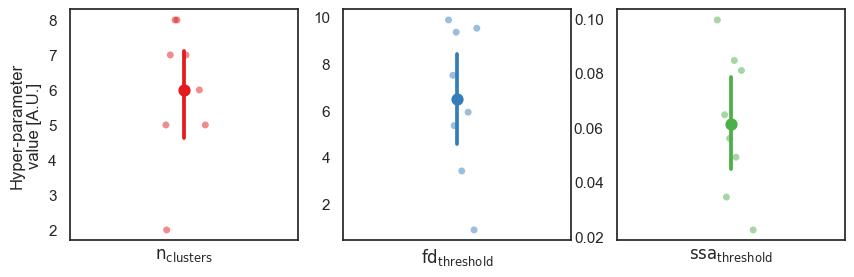

In [88]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

colors = sns.color_palette("Set1")

# Add the mean as a darker point
sns.pointplot(x=np.ones_like(results_nclusters), y=results_nclusters, ax=axes[0], palette=[colors[0]])
sns.pointplot(x=np.ones_like(results_fd), y=results_fd, ax=axes[1], palette=[colors[1]])
sns.pointplot(x=np.ones_like(results_ssa), y=results_ssa, ax=axes[2], palette=[colors[2]])

# Plot the sepal length, sepal width, and petal length distributions
sns.stripplot(x=np.ones_like(results_nclusters), y=results_nclusters, ax=axes[0], palette=[colors[0]], alpha=0.5)
sns.stripplot(x=np.ones_like(results_fd), y=results_fd, ax=axes[1], palette=[colors[1]], alpha=0.5)
sns.stripplot(x=np.ones_like(results_ssa), y=results_ssa, ax=axes[2], palette=[colors[2]], alpha=0.5)



# Adjust the axes labels and titles
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[2].set_xticks([])
axes[0].set_ylabel("Hyper-parameter\nvalue [A.U.]")
axes[0].set_xlabel("$\\text{n}_\\text{clusters}$")
axes[1].set_xlabel("$\\text{fd}_\\text{threshold}$")
axes[2].set_xlabel("$\\text{ssa}_\\text{threshold}$")
# axes[0].set_ylabel("Sepal Length (cm)")
# axes[1].set_ylabel("Sepal Width (cm)")
# axes[2].set_ylabel("Petal Length (cm)")
# axes[0].set_title("Sepal Length by Species")
# axes[1].set_title("Sepal Width by Species")
# axes[2].set_title("Petal Length by Species")

# Show the plot
import matplotlib
matplotlib.rcParams.update({'font.size': 42})
plt.savefig("parameters_distribution.svg")
plt.show()


## Evaluate EQI

Print one EQI evaluation for visualization purposes

Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\045\00004526\s003_2009_09_15\00004526_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


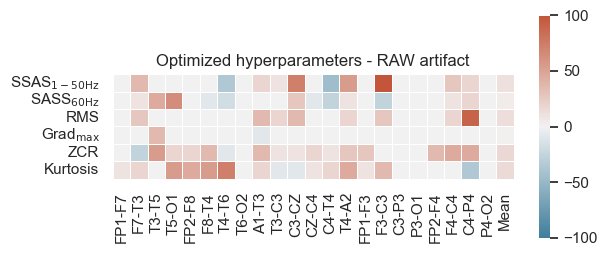

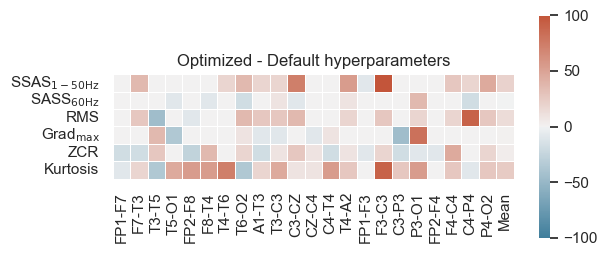

In [75]:
# Settings
plot_eqi = True
file = 4

if (plot_eqi):
    temp_result = list(results.items())[file][1]
    itest = temp_result["test_artifacts"][0]
    optimized_eqi = np.array(temp_result["optimized_eqi"])
    raw_eqi = np.array(temp_result["raw_eqi"])
    default_eqi = np.array(temp_result["default_eqi"])

    # Import data file
    temple = TempleData(temp_result["file_path"])

    # Get artifact data
    artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
    # artifacts_file = fr"/home/araz/Downloads/Araz/csv/labels_{temple.montage_type}.csv"
    temple.get_artifacts_from_csv(artifacts_file)

    [artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
        artifact_type = artifact_type,
        window_length = window_length,
        )
    
    subset_chans = [chan for chan in artifacts_chans[itest] if chan in temple.ch_names]


    # eqi.heatmap(raw_eqi, chans=subset_chans, title="RAW EQI")
    # eqi.heatmap(default_eqi, chans=subset_chans, title="Default EQI")
    # eqi.heatmap(optimized_eqi, chans=subset_chans, title="Optimized EQI")

    eqi.heatmap(
        optimized_eqi - raw_eqi,
        chans = subset_chans,
        title = "Optimized hyperparameters - RAW artifact",
        save_name = "optimized-raw.svg"
        )
    
    eqi.heatmap(
        optimized_eqi - default_eqi,
        chans = subset_chans,
        title = "Optimized - Default hyperparameters",
        save_name = "optimized-default.svg"
        )

## Test optimization results

Use the optimizes hyper-parameters in the test trial.

IndexError: list index out of range

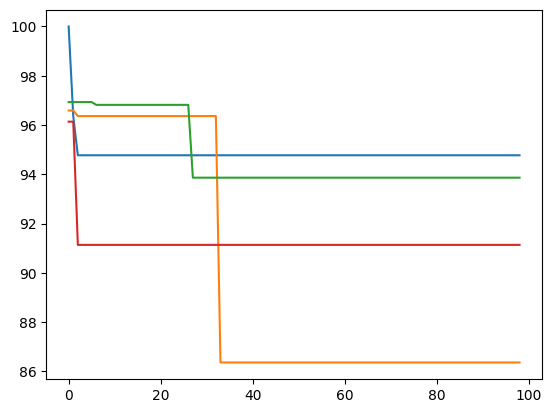

In [ ]:
iteration_errs = []
for iteration_res in iteration_results:
    iteration_errs.append([res[1] for res in iteration_results[iteration_res]])

for i, artifact in enumerate(artifacts_chans[:-1]):
    plt.plot(iteration_errs[i], label = artifact)

plt.legend(
    bbox_to_anchor = (1.05, 1),
    loc = 'upper left',
    borderaxespad = 0
)
plt.title(f"{artifact_type} artifact")
plt.ylabel("Error")
plt.xlabel("Iteration")
plt.show()